# Tune-up Template 

## 0. Chip Layout, Wiring, and Fabrication 

### 0.1 Chip layout

Put your chip layout here

### 0.2 Wiring

Describe your wiring here

### 0.3 Fabrication Parameters

You might know something about your qubits from fabrication, you can put those here before you start:

|                  | QB1               | QB2          | QB3               | QB4               | QB5          | QB6               |
|------------------|-------------------|--------------|-------------------|-------------------|--------------|-------------------|
| Upper Sweet Spot |  |  |  |  |  |  |
| Lower Sweet Spot |  |  |  |  |  |  |
| Resonator        | 7.0G              | 7.2G         | 7.4G              | 7.1G              | 7.3G         | 7.5G              |

## 1. Imports


# Tune-up Template 

## 0. Chip Layout, Wiring, and Fabrication 

### 0.1 Chip layout

Put your chip layout here

### 0.2 Wiring

Describe your wiring here

### 0.3 Fabrication Parameters

You might know something about your qubits from fabrication, you can put those here before you start:

|                  | QB1               | QB2          | QB3               | QB4               | QB5          | QB6               |
|------------------|-------------------|--------------|-------------------|-------------------|--------------|-------------------|
| Upper Sweet Spot |  |  |  |  |  |  |
| Lower Sweet Spot |  |  |  |  |  |  |
| Resonator        | 7.0G              | 7.2G         | 7.4G              | 7.1G              | 7.3G         | 7.5G              |

## 1. Imports


In [1]:
# convenience Import for all LabOne Q Functionality
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.contrib.example_helpers.data_analysis.data_analysis import (
    func_invLorentz,
    func_osc,
    fit_Spec,
    fit_Rabi,
    func_decayOsc,
    fit_Ramsey,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import (
    plot_simulation,
    plot_results,
)

# descriptor imports
from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor

# for saving results and pulse sheets
from pathlib import Path
import datetime
import time
import scipy
import json
import yaml
from ruamel.yaml import YAML

import matplotlib.pyplot as plt
import numpy as np

from helpers.tuneup_helper import (
    flatten,
    rotate_to_real_axis,
    calc_readout_weight,
    evaluate_rabi,
    evaluate_ramsey,
    evaluate_T1,
    analyze_ACStark,
    analyze_qspec,
    create_x180,
    create_x180_ef,
    create_x90,
    create_x90_ef,
    update_qubit_parameters_and_calibration,
    load_qubit_parameters,
    create_transmon,
    save_results,
    plot_with_trace_rabi,
)

from helpers.experiment_library import (
    resonator_spectroscopy_parallel_CW_full_range,
    resonator_spectroscopy_single,
    readout_pulse,
    integration_kernel,
    pulsed_resonator_spectroscopy_single,
    qubit_spectroscopy_parallel,
    qubit_spectroscopy_single,
    res_spectroscopy_pulsed_amp_sweep,
    amplitude_rabi_parallel,
    amplitude_rabi_single,
    ramsey_parallel,
    t1_parallel,
    ecr_amplitude_sweep,
    create_freq_sweep,
    qubit_drive_pulse,
    create_amp_sweep,
    readout_gauss_square_pulse,
    qubit_gaussian_pulse,
)

import logging

from helpers.experiment_library import qubit_spectroscopy_single

## 2. Set-up


### Emulation Mode


In [2]:
emulate = False

### Database Set-up


In [3]:
# set up connection to database
demo_setup_db = DataStore("laboneq_data/setup_database.db")

demo_results_db = DataStore("laboneq_data/results_database.db")

# # check if data is already stored in database
# for key in demo_setup_db.keys():
#     print(key)

### Device Set-up


In [4]:
from textwrap import dedent

descriptor = dedent(
    """\
instruments:
  SHFQC:
    - address: dev12250
      uid: device_shfqc
connections:

  device_shfqc:
    - iq_signal: q0/measure_line
      ports: QACHANNELS/0/OUTPUT
    - acquire_signal: q0/acquire_line
      ports: QACHANNELS/0/INPUT
      
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/3/OUTPUT
"""
)
demo_setup = DeviceSetup.from_descriptor(
    descriptor, server_host="localhost", server_port=8004, setup_name="MySetup"
)

### Apply Calibration from File


In [5]:
qubit_parameters = load_qubit_parameters()

qubit_parameters["local_oscillators"]["readout_lo"]["value"] = 7.0e9

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)
print(demo_setup.get_calibration())

Calibration(
│   calibration_items={
│   │   '/logical_signal_groups/q0/drive_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_drive_ge_osc',
│   │   │   │   frequency=748547178.3590612,
│   │   │   │   modulation_type=ModulationType.HARDWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_drive_local_osc',
│   │   │   │   frequency=5000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=10,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/logical_signal_groups/q0/measure_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_measure_osc',
│   │   │   │   frequency=255000000.0,
│   │   │   │   modulation_type=ModulationType.SOFTWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-25,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/logical_signal_groups/q0/acquire_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_acquire_osc',
│   │   │   │   frequency=255000000.0,
│   │   │   │   modulation_type=ModulationType.SOFTWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=2.4e-07,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-5,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/qachannels_0_output': SignalCalibration(
│   │   │   oscillator=None,
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-25,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/qachannels_0_input': SignalCalibration(
│   │   │   oscillator=None,
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=2.4e-07,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-5,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/sgchannels_3_output': SignalCalibrat

### Create and Connect to a QCCS Session 

Establishes the connection to the instruments and readies them for experiments


In [6]:
# create and connect to a session
session = Session(device_setup=demo_setup)
session.connect(do_emulation=emulate, reset_devices=True)

2023.09.20 09:23:26.002 laboneq.controller.laboneq_logging INFO   Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is c:\Users\ZI_at_PSI\code\Tune_up_scripts\laboneq_output\log
2023.09.20 09:23:26.003 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.20 09:23:26.004 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.20 09:23:26.056 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.20 09:23:27.482 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.20 09:23:27.632 laboneq.controller.devices.device_collection INFO   The device setup is configured


## CW Spectroscopy


In [14]:
cw_spectroscopy_exp = resonator_spectroscopy_parallel_CW_full_range(
    transmon_list,
    create_freq_sweep("outer", 6e9, 8e9, 3),
    create_freq_sweep("inner", -500e6, 500e6, 1001),
)

compiled_cw_spectroscopy_exp = session.compile(cw_spectroscopy_exp)
cw_spectroscopy_results = session.run(compiled_cw_spectroscopy_exp)

2023.09.20 09:17:53.909 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.20 09:17:54.209 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.20 09:17:54.326 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 25
2023.09.20 09:17:54.327 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 0
2023.09.20 09:17:54.327 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.09.20 09:17:54.924 laboneq.controller.controller  INFO   Starting near-time execution...
2023.09.20 09:17:55.236 laboneq.controller.controller  INFO   Estimated RT execution time: 10.01 s.
2023.09.20 09:18:05.678 laboneq.controller.controller  INFO   Estimated RT execution time: 10.01 s.
2023.09.20 09:18:16.166 laboneq.controller.controller  INFO   Estimated RT execution time: 10.01 s.
2023.09.20 09:18:26.406 laboneq.controller.controller  INFO   Finished near-time execution.


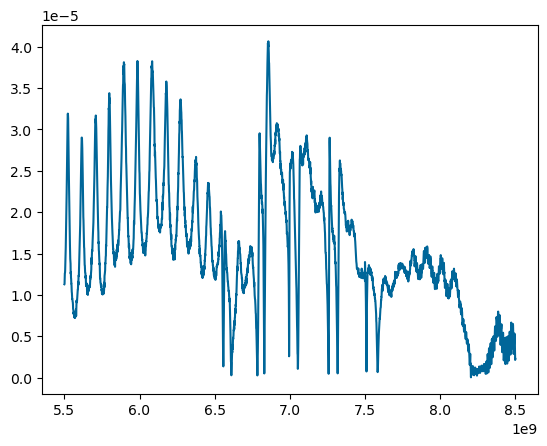

In [15]:
# access and plot results of one 8GHz sweep
full_data = abs(cw_spectroscopy_results.get_data("resonator_spectroscopy_q0"))

outer = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[0]
inner = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[1]
full_sweep = np.array(flatten([out + inner for out in outer]))

plt.plot(full_sweep, np.array(flatten([data for data in full_data])))

In [16]:
save_results(demo_results_db, cw_spectroscopy_results, "cw_spec_results", "full_sweep")

# Baseband sweep CW spectroscopy

2023.09.20 09:19:45.029 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.20 09:19:45.030 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.20 09:19:45.035 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.20 09:19:46.429 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.20 09:19:46.571 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.20 09:19:46.819 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.20 09:19:46.917 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.20 09:19:46.932 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 25
2023.09.20 09:19:46.933 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 0
2023.09.20 09:19:46.933 laboneq.compiler.workflow.co

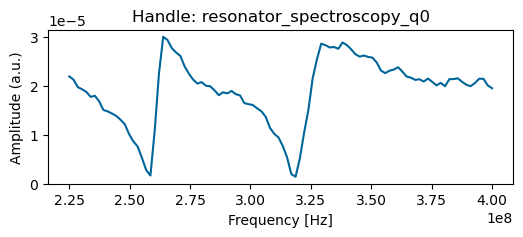

In [17]:
single_cw = resonator_spectroscopy_single(
    transmon_list[0],
    create_freq_sweep(f"{transmon_list[0].uid}_sweep", 225e6, 400e6, 100),
    measure_range=-25,
    acquire_range=-5,
)
session.connect(do_emulation=emulate, reset_devices=True)
compiled_single_cw_spect_exp = session.compile(single_cw)
cw_spectroscopy_results = session.run(compiled_single_cw_spect_exp)
plot_results(cw_spectroscopy_results)

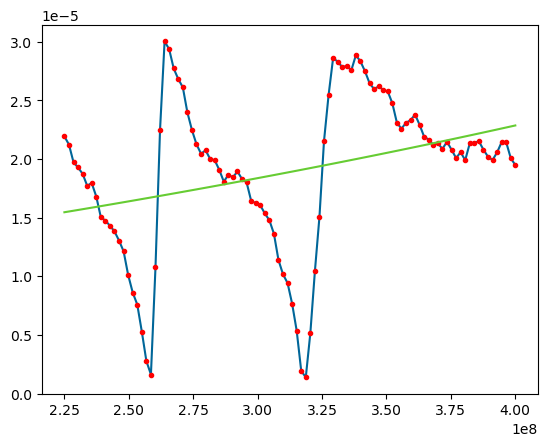

2105256957.0513577

In [18]:
analyze_qspec(res=cw_spectroscopy_results, handle="resonator_spectroscopy_q0")

In [19]:
first_readout_res = 7.0e9 + 2.55e8

In [20]:
qubit_parameters["qubits"]["q0"]["readout_resonator_frequency"][
    "value"
] = first_readout_res

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

## Spectroscopy vs Power - "Punchout" NOT TESTED


In [ ]:
freq_upper = (
    transmon_list[0].parameters.readout_resonator_frequency
    - transmon_list[0].parameters.readout_lo_frequency
    + 50e6
)
freq_lower = (
    transmon_list[0].parameters.readout_resonator_frequency
    - transmon_list[0].parameters.readout_lo_frequency
    - 50e6
)

amp_sweep = SweepParameter(
    uid="amp_sweep2",
    values=np.logspace(start=np.log10(0.001), stop=np.log10(1), num=21),
)

punchout = res_spectroscopy_pulsed_amp_sweep(
    qubit=transmon_list[0],
    integration_kernel=integration_kernel,
    readout_pulse=readout_gauss_square_pulse,
    frequency_sweep=create_freq_sweep(
        f"{transmon_list[0].uid}_sweep", freq_lower, freq_upper, 1001
    ),
    amplitude_sweep=amp_sweep,
    num_averages=2**10,
    measure_range=-25,
    acquire_range=-5,
)

comp_punchout = session.compile(punchout)
punchout_result = session.run(comp_punchout)

In [ ]:
plot_results(punchout_result)

In [ ]:
save_results(
    demo_results_db,
    punchout_result,
    "punchout",
    "neg_25_meas_neg_5_acq_range",
)

In [ ]:
qubit_parameters["multiplex_readout"]["readout_amplitude"]["value"] = 0.55

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

## Continue with your tune-up experiments:

* Qubit Spec
* Rabi
* Ramsey
* T1
* Hahn Echo

What's after that? There are many ways to go once you have done the basics:

* Drag pulse tune-up
* Single shot readout
* Active reset
* f-level tune-up
* Two qubit gates
* Tomography
* RB

# Qubit Spectroscopy

In [21]:
def gen_const_pulse(qubit, length=5e-5,amplitude=1.0):
    return pulse_library.const(uid=f"{qubit}",length=length,amplitude=amplitude, can_compress=True)

In [22]:
qubit_parameters["qubits"]["q0"]["drive_range_ge"]["value"]=-25
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [23]:

qubit_spec_exp = qubit_spectroscopy_single(
    qubit = transmon_list[0],
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    qubit_spectroscopy_pulse=gen_const_pulse,
    qspec_range=50e6,
    qspec_num=501,
    num_averages=2**8,
)


2023.09.20 09:20:13.828 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.20 09:20:13.830 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.20 09:20:13.838 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.20 09:20:15.237 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.20 09:20:15.376 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.20 09:20:15.608 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.20 09:20:15.658 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.20 09:20:17.103 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 43
2023.09.20 09:20:17.104 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8064
2023.09.20 09:20:17.104 laboneq.compiler.workflow

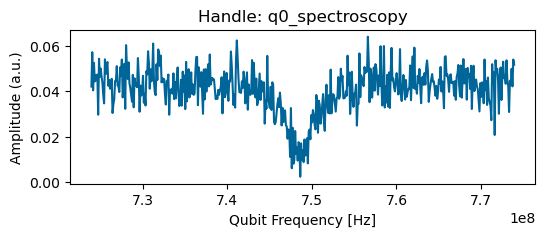

In [24]:
session.connect(do_emulation=emulate,reset_devices=True)
qspec_res=session.run(qubit_spec_exp)
plot_results(qspec_res)

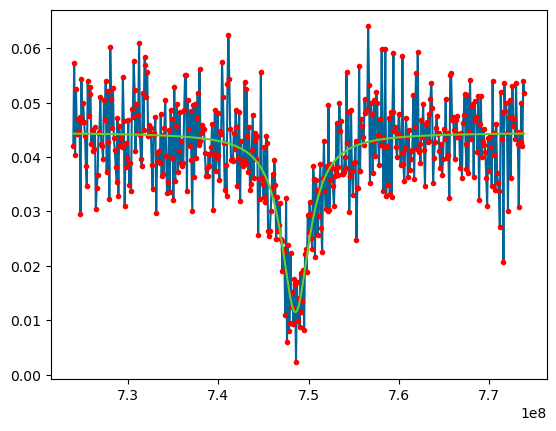

748547178.3590614


In [26]:
qubit_resonance=analyze_qspec(qspec_res,"q0_spectroscopy",f0=7.5e8,a=0.03,gamma=1E6, flip=True)
print(qubit_resonance)

### Update qubit resonance

In [27]:
qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"][
    "value"
] =  qubit_parameters["qubits"]["q0"]["drive_lo_frequency"][
    "value"
] + qubit_resonance
print(qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"]["value"])
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

5748547178.359061


## Amplitude Rabi

In [7]:
qubit_parameters["qubits"]["q0"]["drive_range_ge"]["value"]=10
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [8]:

amp_rabi = amplitude_rabi_single(
    qubit=transmon_list[0],
    drive_pulse=qubit_gaussian_pulse,
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    amplitude_sweep=LinearSweepParameter(uid="amplitude_sweep", start=0.0, stop=1, count=51),
    num_averages=2**10,
    pi_amplitude=0.32,
    cal_trace=True,
)

compiled_rabi = session.compile(amp_rabi)
session.connect(do_emulation=emulate, reset_devices=True)
rabi_res = session.run(compiled_rabi)


2023.09.20 09:23:43.959 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.20 09:23:43.970 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.20 09:23:44.008 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 294
2023.09.20 09:23:44.009 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8832
2023.09.20 09:23:44.010 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.09.20 09:23:44.011 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.20 09:23:44.012 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.20 09:23:44.019 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.20 09:23:45.448 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.20 09:23:45.587 laboneq.controller.devices.device

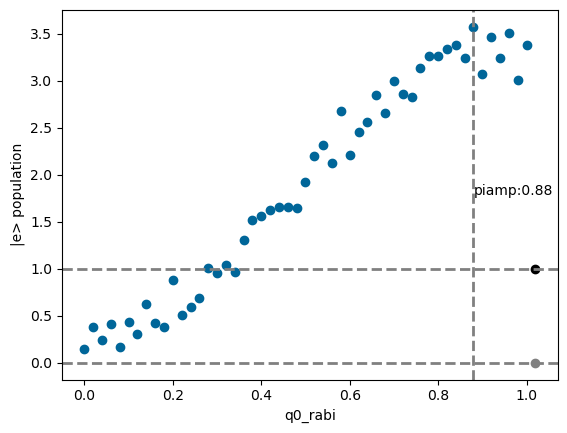

In [9]:
plot_with_trace_rabi(rabi_res)

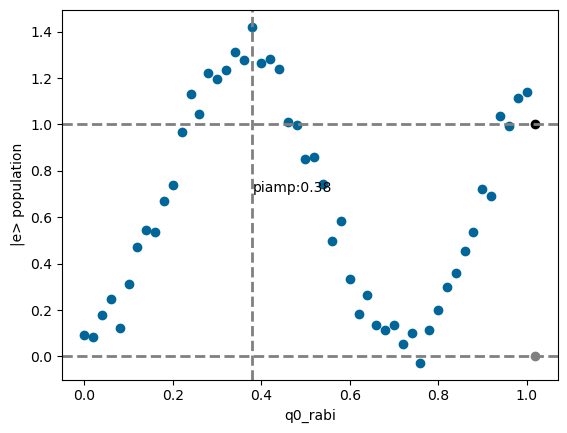

In [65]:
plot_with_trace_rabi(rabi_res)

In [24]:
qubit_parameters["qubits"]["q0"]["amplitude_pi"][
    "value"
] =0.38
qubit_parameters["qubits"]["q0"]["amplitude_pi2"][
    "value"
] =0.38/2
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

## Ramsey

In [25]:
def ramsey_parallel(
    qubits,
    drive_pulse: callable,
    integration_kernel: callable,
    readout_pulse: callable,
    delay_sweep,
    num_averages=2**10,
    cal_trace=False,
    pi_amplitude=0.5,
):
    exp_ramsey = Experiment(
        uid="Ramsey Exp",
        signals=flatten(
            [
                [
                    ExperimentSignal(
                        f"drive_{qubit.uid}", map_to=qubit.signals["drive"]
                    ),
                    ExperimentSignal(
                        f"measure_{qubit.uid}", map_to=qubit.signals["measure"]
                    ),
                    ExperimentSignal(
                        f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]
                    ),
                ]
                for qubit in qubits
            ]
        ),
    )

    ## define Ramsey experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_ramsey.acquire_loop_rt(
        uid="ramsey_shots",
        count=num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        repetition_mode=RepetitionMode.AUTO,
    ):
        # inner loop - real time sweep of Ramsey time delays
        with exp_ramsey.sweep(
            uid="ramsey_sweep", parameter=delay_sweep, alignment=SectionAlignment.RIGHT
        ):
            for qubit in qubits:
                # play qubit excitation pulse - pulse amplitude is swept
                ramsey_pulse = drive_pulse(qubit)
                with exp_ramsey.section(
                    uid=f"{qubit.uid}_excitation", alignment=SectionAlignment.RIGHT
                ):
                    exp_ramsey.play(signal=f"drive_{qubit.uid}", pulse=ramsey_pulse)
                    exp_ramsey.delay(signal=f"drive_{qubit.uid}", time=delay_sweep)
                    exp_ramsey.play(signal=f"drive_{qubit.uid}", pulse=ramsey_pulse)
                # readout pulse and data acquisition
                # measurement
                with exp_ramsey.section(
                    uid=f"readout_{qubit.uid}", play_after=f"{qubit.uid}_excitation"
                ):
                    exp_ramsey.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_ramsey",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel(qubit),
                        reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                    )
                    
                
                if cal_trace:
                    with exp_ramsey.section(uid="cal_trace_gnd"):
                        exp_ramsey.measure(
                            measure_signal=f"measure_{qubit.uid}",
                            measure_pulse=readout_pulse(qubit),
                            handle=f"{qubit.uid}_ramsey_cal_trace",
                            acquire_signal=f"acquire_{qubit.uid}",
                            integration_kernel=integration_kernel(qubit),
                            reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                        )
                    with exp_ramsey.section(uid="cal_trace_exc"):
                        exp_ramsey.play(
                            signal=f"drive_{qubit.uid}",
                            pulse=drive_pulse(qubit),
                            amplitude=pi_amplitude,
                        )
                        
                        exp_ramsey.measure(
                            measure_signal=f"measure_{qubit.uid}",
                            measure_pulse=readout_pulse(qubit),
                            handle=f"{qubit.uid}_ramsey_cal_trace",
                            acquire_signal=f"acquire_{qubit.uid}",
                            integration_kernel=integration_kernel(qubit),
                            reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                        )

    return exp_ramsey

In [26]:
transmon_list[0].parameters.user_defined["amplitude_pi2"]

0.19

In [36]:
print(demo_setup.get_calibration())

Calibration(
│   calibration_items={
│   │   '/logical_signal_groups/q0/drive_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_drive_ge_osc',
│   │   │   │   frequency=748915747.5176592,
│   │   │   │   modulation_type=ModulationType.HARDWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_drive_local_osc',
│   │   │   │   frequency=5000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=10,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/logical_signal_groups/q0/measure_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_measure_osc',
│   │   │   │   frequency=255000000.0,
│   │   │   │   modulation_type=ModulationType.SOFTWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-25,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/logical_signal_groups/q0/acquire_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_acquire_osc',
│   │   │   │   frequency=255000000.0,
│   │   │   │   modulation_type=ModulationType.SOFTWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=2.4e-07,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-5,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/qachannels_0_output': SignalCalibration(
│   │   │   oscillator=None,
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-25,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/qachannels_0_input': SignalCalibration(
│   │   │   oscillator=None,
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=2.4e-07,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-5,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/sgchannels_3_output': SignalCalibrat

In [33]:
def qubit_gaussian_halfpi_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pulse_drive_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude = qubit.parameters.user_defined["amplitude_pi2"],
    )

In [34]:
delay_sweep = LinearSweepParameter(uid="delay_sweep", start=0, stop=500e-9, count=20)
ramsey_exp = ramsey_parallel(transmon_list, qubit_gaussian_halfpi_pulse, integration_kernel, readout_pulse, delay_sweep, num_averages=2**10, 
                             cal_trace=True)
session.connect(reset_devices=True)
compiled_exp = session.compile(ramsey_exp)
res_ramsey=session.run(compiled_exp)
#show_pulse_sheet(ramsey_exp.uid,compiled_exp)

2023.09.20 08:49:29.994 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.20 08:49:29.995 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.20 08:49:30.001 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.20 08:49:31.499 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.20 08:49:31.646 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.20 08:49:31.834 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.20 08:49:31.843 laboneq.compiler.scheduler.scheduler WARNING Topological order of the acquires for handle q0_ramsey_cal_trace does not match time order.
2023.09.20 08:49:31.843 laboneq.compiler.scheduler.scheduler WARNING Topological order of the acquires for handle q0_ramsey_cal_trace does not match time order.
2023.09.20 08

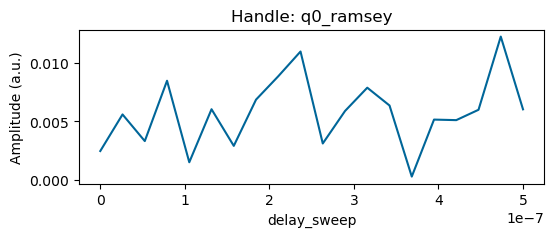

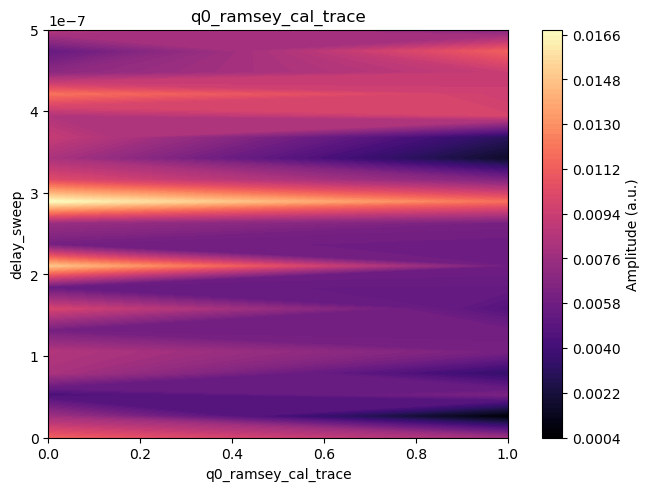

In [35]:
plot_results(res_ramsey)

In [90]:
def plot_with_trace_ramsey(res):
    handles = list(res.acquired_results.keys())
    res1 = np.asarray(res.get_data(handles[0]))
    res_cal_trace= np.asarray(res.get_data(handles[1]))
    axis1 = res.get_axis(handles[0])[0]
    delta_x = axis1[-1]-axis1[-2]
    axis2 = np.linspace(axis1[-1]+delta_x,axis1[-1] + 2*delta_x,2)

    delta_vec = res_cal_trace[1] -res_cal_trace[0]
    angle = np.angle(delta_vec)
    rd = []
    for r in [res1,res_cal_trace]:
        r = r - res_cal_trace[0]
        r = r * np.exp(-1j*angle)
        r = r/ np.abs(delta_vec)
        rd.append(r)
        
    pi_amp = axis1[np.argmax(np.real(rd[0]))]

    plt.xlabel(handles[0])
    plt.ylabel("|e> population")
    plt.plot(axis1,np.real(rd[0]),'o')
    plt.plot(axis2[0],np.real(rd[1][0]),'o', color="gray")
    plt.plot(axis2[0],np.real(rd[1][1]),'o', color="black")
    plt.axhline(y=np.real(rd[1][0]), color='gray', linestyle='--', linewidth=2)
    plt.axhline(y=np.real(rd[1][1]), color='gray', linestyle='--', linewidth=2)
    # plt.axvline(x=pi_amp, color='gray', linestyle='--', linewidth=2)
    # plt.text(x=pi_amp,y = max(np.real(rd[0]))/2, s= f"piamp:{pi_amp}")
    plt.plot()

In [91]:
plot_with_trace_ramsey(res_ramsey)

ValueError: operands could not be broadcast together with shapes (20,) (2,) 